In [1]:
# One class Support Vector Machine

In [2]:
import pandas as pd
import time
from sklearn.svm import OneClassSVM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  pairwise 
import sklearn.model_selection

In [10]:
start = time.time()
df = pd.read_csv('CleanedDay3_5mill_RepSamp.csv')
end = time.time()
print(end - start)

9.671661376953125


In [11]:
df2 = df.sample(n=1000000)
df2.to_csv('1mill_sample_anomaly.csv')

In [13]:
# Need to clean the data by categorizing ports and then one hot encoding them. In
# the meantime, just using numerical values

In [12]:
dfNum = df2[['Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']]
dfNum.head()

,Duration,SrcPackets,DstPackets,SrcBytes,DstBytes
2615150,0,11,7,1577,3911
3424367,815,6,6,474,2205
871645,1,7,7,640,1365
4456841,1,4,3,216,160
3515765,1,9,7,6871,587


In [14]:
start = time.time()
ocsvm = OneClassSVM(nu=0.01, kernel='poly') # 2 vs 3 doesn't make a difference for this sample
ocsvm.fit(dfNum)
labels = ocsvm.predict(dfNum)
end = time.time()
print(end - start)

5300.297967195511


In [15]:
# Intra cluster distance 
start = time.time()
dfNum['Outlier'] = labels
benign = dfNum[dfNum['Outlier'] == 1]
anomalies = dfNum[dfNum['Outlier'] == -1]
benign_centroid = benign.mean().values
full_centroid = dfNum.mean().values

full_spread = 0
for index, row in dfNum.iterrows():
    d = np.sum(np.square(full_centroid - row.values))
    full_spread = full_spread + d
    
benign_spread = 0
for index, row in benign.iterrows():
    d = np.sum(np.square(benign_centroid - row.values))
    benign_spread = benign_spread + d
    
ratio = (full_spread / dfNum.shape[0]) / (benign_spread / benign.shape[0])
print(ratio)
end = time.time()
print(end - start)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.9885603626511567
88.19892978668213


In [16]:
# Appending the labels as a column to the ensembling dataframe
df = pd.read_csv('1mill_anomaly_ensemble_df.csv')
df['OCSVM_0.01_Labels'] = labels
df.head()

In [17]:
df.to_csv('1mill_anomaly_ensemble_df.csv')

In [20]:
# Removing 'Port' from the port names and grouping ports into 3 categories
df2['DstPort'] = df2['DstPort'].str.replace('Port', '')
df2['DstPort'] = df2['DstPort'].astype(int)
df2['DstPortCategory'] = np.where(df2['DstPort']<=1023, 'System Ports', 'User Ports')
df2['DstPortCategory'][df2['DstPort']>=49152] = 'Dynamic and/or Private Ports'

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
# Chi-Squared Test to Test Whether Anomalous and Benign Five-Tuples have significantly 
# differnt port dist
df2['Outlier'] = labels
cont_tab = pd.crosstab(index=df2['Outlier'], columns=df2['DstPortCategory'])
print(cont_tab)
from scipy import stats
stats.chi2_contingency(cont_tab)

DstPortCategory  Dynamic and/or Private Ports  System Ports  User Ports
Outlier                                                                
-1                                       4313          2243        4884
 1                                     194655        516231      277674


(5017.356227717326, 0.0, 2, array([[  2276.19392,   5931.34256,   3232.46352],
        [196691.80608, 512542.65744, 279325.53648]]))

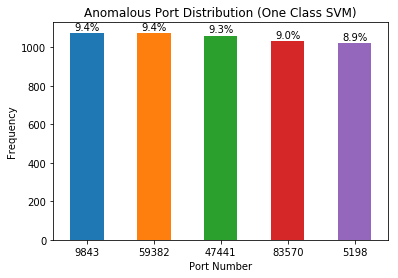

In [23]:
# Creating a plot of the ports for anomalous five tuples
anomalies2 = df2[df2['Outlier']==-1]
freq_series = pd.Series(anomalies2['DstPort'].value_counts().head(5).values)
x_labels = pd.Series(anomalies2['DstPort'].value_counts().head(5).index)
ax = freq_series.plot(kind='bar')
ax.set_title('Anomalous Port Distribution (One Class SVM)')
ax.set_xlabel('Port Number')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['DstPort'].value_counts().head(6)*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('1CSVM_anomalous_portDist_0.01contam.png')

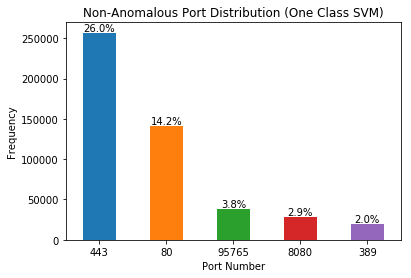

In [24]:
# Creating a plot of the ports for non- anomalous five tuples
anomalies2 = df2[df2['Outlier']==1]
freq_series = pd.Series(anomalies2['DstPort'].value_counts().head(5).values)
x_labels = pd.Series(anomalies2['DstPort'].value_counts().head(5).index)
ax = freq_series.plot(kind='bar')
ax.set_title('Non-Anomalous Port Distribution (One Class SVM)')
ax.set_xlabel('Port Number')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['DstPort'].value_counts().head(6)*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('!SVM_nonanomalous_portDist_0.01contam.png')

In [25]:
# Chi-Squared Test to Test Whether Anomalous and Benign Five-Tuples have significantly 
# differnt protocol dist
cont_tab2 = pd.crosstab(index=df2['Outlier'], columns=df2['Protocol'])
print(cont_tab2)
from scipy import stats
stats.chi2_contingency(cont_tab2)

Protocol      6      17
Outlier                
-1         11440      0
 1        945138  43422


(524.2491189012161,
 5.036130409311002e-116,
 1,
 array([[1.09432523e+04, 4.96747680e+02],
        [9.45634748e+05, 4.29252523e+04]]))

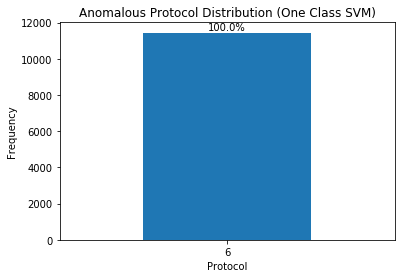

In [26]:
# Creating a plot of the protocols for anomalous five tuples
anomalies2 = df2[df2['Outlier']==-1]
freq_series = pd.Series(anomalies2['Protocol'].value_counts().values)
x_labels = pd.Series(anomalies2['Protocol'].value_counts().index)
ax = freq_series.plot(kind='bar')
ax.set_title('Anomalous Protocol Distribution (One Class SVM)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['Protocol'].value_counts()*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('1SVM_anomalous_protocolDist_0.01contam.png')

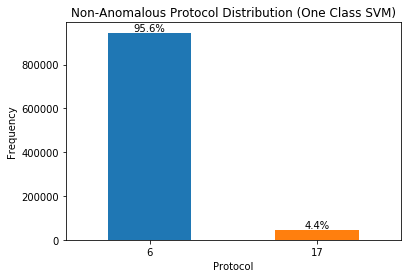

In [28]:
# Creating a plot of the protocols for non-anomalous five tuples
benign2 = df2[df2['Outlier']==1]
freq_series = pd.Series(benign2['Protocol'].value_counts().values)
x_labels = pd.Series(benign2['Protocol'].value_counts().index)
ax = freq_series.plot(kind='bar')
ax.set_title('Non-Anomalous Protocol Distribution (One Class SVM)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(benign2['Protocol'].value_counts()*100/len(benign2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('1SVM_benign_protocolDist_0.01contam.png')

In [17]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [18]:
# Plotting PCA to Visualize Anomalies
# Scaling for PCA
start = time.time()
pre = preprocessing.scale(dfNum[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]])
pre = pd.DataFrame.from_records(pre, columns = ["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"])
print(pre.head())
end = time.time()
print(end - start)

   Duration  SrcPackets  DstPackets  SrcBytes  DstBytes
0  0.134151   -0.007914   -0.006129 -0.014218 -0.004909
1 -0.080895   -0.007190   -0.005891 -0.013638 -0.004790
2 -0.028818   -0.007045   -0.005812 -0.013482 -0.004729
3 -0.080895   -0.007914   -0.006129 -0.014221 -0.004910
4 -0.080895   -0.007624   -0.006050 -0.014136 -0.004885
1.8696460723876953


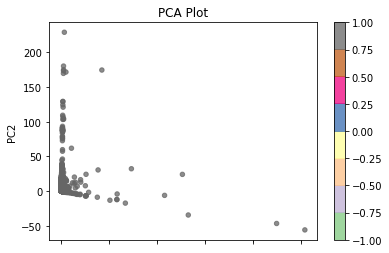

45.54799127578735


In [19]:
# PCA plot of protocol and numerical values-- color coded by Protocol
start = time.time()
pcaDF = pre[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]]
pca = PCA(n_components=2).fit_transform(pcaDF)
pcdf = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])
pcdf.plot(x="PC1", y="PC2", kind='scatter', title='PCA Plot', 
          c=dfNum['Outlier'] , legend=True, colormap = 'Accent', alpha = 0.75)
plt.savefig('1mill_PCA_1SVM.png')
plt.show()
end = time.time()
print(end - start)